# 最終課題 

## スクレイピング

In [35]:
# db_setup.py
import sqlite3

conn = sqlite3.connect("suumo.db")
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS properties (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT,
    rent INTEGER,
    walk_minutes INTEGER,
    layout TEXT,
    area REAL,
    age INTEGER,
    ward TEXT,
    url TEXT
)
""")

conn.commit()
conn.close()


In [36]:
import requests
import time
import re
import sqlite3
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# =====================
# 基本設定
# =====================
BASE_URL = "https://suumo.jp"
SEARCH_URL = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/"
DB_PATH = "suumo.db"

PARAMS = {
    "ar": "030",     # 関東
    "bs": "040",     # 賃貸
    "ta": "13",      # 東京都
    "sc": "13112",   # 世田谷区
}

HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; UniversityAssignmentBot/1.0)"
}

# =====================
# DB初期化
# =====================
def init_db():
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("""
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT,
        rent INTEGER,
        walk_minutes INTEGER,
        layout TEXT,
        area REAL,
        age INTEGER,
        ward TEXT,
        url TEXT
    )
    """)
    conn.commit()
    conn.close()

# =====================
# 共通処理
# =====================
def get_soup(url, params=None):
    res = requests.get(url, params=params, headers=HEADERS, timeout=10)
    res.raise_for_status()
    return BeautifulSoup(res.text, "html.parser")

def parse_int(text):
    if text is None:
        return None
    nums = re.findall(r"\d+", text)
    return int(nums[0]) if nums else None

# =====================
# 一覧ページ → 詳細URL取得
# =====================
def extract_detail_urls(soup):
    urls = []
    for a in soup.select("a.js-cassette_link_href"):
        href = a.get("href")
        if href:
            urls.append(urljoin(BASE_URL, href))
    return list(set(urls))

# =====================
# 徒歩分数取得（重要修正ポイント）
# =====================
def extract_walk_minutes(soup):
    minutes = []
    texts = soup.find_all(text=re.compile("徒歩"))
    for t in texts:
        m = re.search(r"徒歩\s*(\d+)\s*分", t)
        if m:
            minutes.append(int(m.group(1)))
    return min(minutes) if minutes else None


# =====================
# 詳細ページ解析
# =====================
def extract_property_data(soup, url):
    try:
        # 物件名
        h1 = soup.select_one("h1")
        name = h1.get_text(strip=True) if h1 else None

        # 家賃
        rent_tag = soup.find("span", class_="property_view_note-emphasis")
        rent = parse_int(rent_tag.get_text()) if rent_tag else None

        # 徒歩分数
        walk_minutes = extract_walk_minutes(soup)

        layout = None
        area = None
        age = None

        # 基本情報テーブル
        rows = soup.select("table.property_view_table tr")
        for tr in rows:
            th = tr.find("th")
            td = tr.find("td")
            if not th or not td:
                continue

            label = th.get_text(strip=True)
            value = td.get_text(strip=True)

            if label == "間取り":
                layout = value
            elif label == "専有面積":
                area = float(value.replace("m2", "").replace("㎡", ""))
            elif label == "築年数":
                age = parse_int(value)

        return {
            "name": name,
            "rent": rent,
            "walk_minutes": walk_minutes,
            "layout": layout,
            "area": area,
            "age": age,
            "ward": "世田谷区",
            "url": url
        }

    except Exception as e:
        print("解析失敗:", url, e)
        return None

# =====================
# DB保存
# =====================
def save_to_db(data):
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("""
    INSERT INTO properties
    (name, rent, walk_minutes, layout, area, age, ward, url)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        data["name"],
        data["rent"],
        data["walk_minutes"],
        data["layout"],
        data["area"],
        data["age"],
        data["ward"],
        data["url"]
    ))
    conn.commit()
    conn.close()

# =====================
# メイン処理
# =====================
def main():
    init_db()

    for page in range(1, 6):  # 取得ページ数（控えめ）
        print(f"--- page {page} ---")
        PARAMS["page"] = page

        soup = get_soup(SEARCH_URL, PARAMS)
        detail_urls = extract_detail_urls(soup)
        print(f"  物件数: {len(detail_urls)}")

        for url in detail_urls:
            detail_soup = get_soup(url)
            data = extract_property_data(detail_soup, url)

            if data and data["rent"] and data["walk_minutes"]:
                save_to_db(data)

            time.sleep(1.5)  # サーバ負荷軽減

        time.sleep(2)

if __name__ == "__main__":
    main()


--- page 1 ---
  物件数: 182


/var/folders/5b/274q79c16fdgkb17d9v5dhg80000gn/T/ipykernel_30311/3555289548.py:78: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  texts = soup.find_all(text=re.compile("徒歩"))


--- page 2 ---
  物件数: 157
--- page 3 ---
  物件数: 78
--- page 4 ---
  物件数: 81
--- page 5 ---
  物件数: 65


## グラフを描画

データ件数: 554


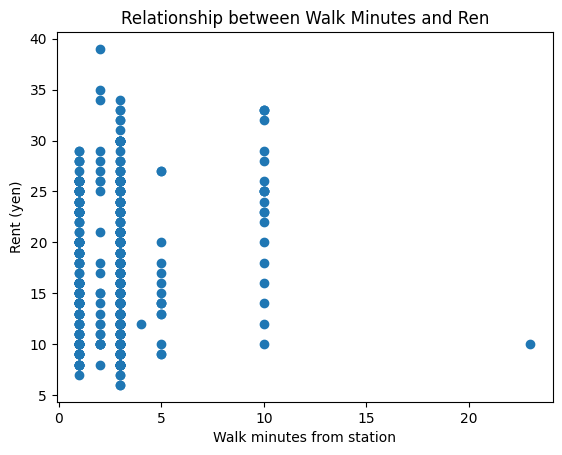

In [41]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = "suumo.db"

def load_dataframe():
    conn = sqlite3.connect(DB_PATH)
    query = """
    SELECT
        rent,
        walk_minutes
    FROM properties
    WHERE
        rent IS NOT NULL
        AND walk_minutes IS NOT NULL
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def plot_scatter(df):
    plt.figure()
    plt.scatter(df["walk_minutes"], df["rent"])
    plt.xlabel("Walk minutes from station")
    plt.ylabel("Rent (yen)")
    plt.title("Relationship between Walk Minutes and Ren")
    plt.show()

if __name__ == "__main__":
    df = load_dataframe()
    print(f"データ件数: {len(df)}")
    plot_scatter(df)


In [42]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

class RealEstateAnalyzer:
    def __init__(self, db_path):
        self.db_path = db_path

    def load_data(self, ward=None):
        conn = sqlite3.connect(self.db_path)

        query = """
        SELECT
            rent,
            walk_minutes
        FROM properties
        WHERE
            rent IS NOT NULL
            AND walk_minutes IS NOT NULL
        """

        if ward:
            query += " AND ward = ?"
            df = pd.read_sql_query(query, conn, params=(ward,))
        else:
            df = pd.read_sql_query(query, conn)

        conn.close()
        return df

    def plot_scatter(self, df):
        plt.figure()
        plt.scatter(df["walk_minutes"], df["rent"])
        plt.xlabel("Walk minutes from station")
        plt.ylabel("Rent (yen)")
        plt.title("Walk Minutes vs Rent")
        plt.show()

    def plot_average_by_walk(self, df):
        df = df.copy()
        df["walk_cat"] = pd.cut(
            df["walk_minutes"],
            bins=[0, 5, 10, 15, 20, 60],
            labels=["~5", "6-10", "11-15", "16-20", "21~"]
        )

        avg = df.groupby("walk_cat")["rent"].mean()

        plt.figure()
        avg.plot(kind="bar")
        plt.xlabel("Walk minutes category")
        plt.ylabel("Average rent (yen)")
        plt.title("Average Rent by Walk Minutes")
        plt.show()

    def calc_correlation(self, df):
        return df["walk_minutes"].corr(df["rent"])


分析件数: 554
相関係数: 0.09365498556451861


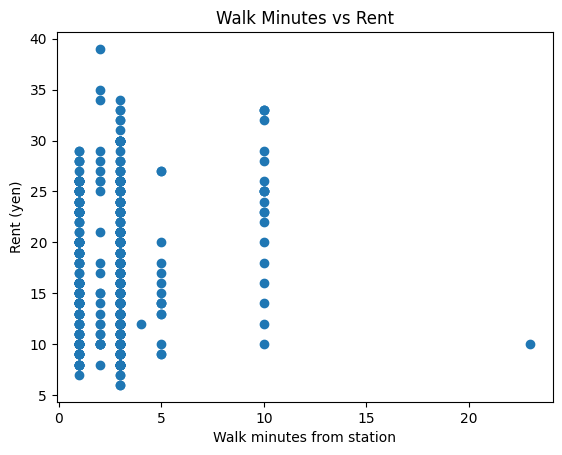

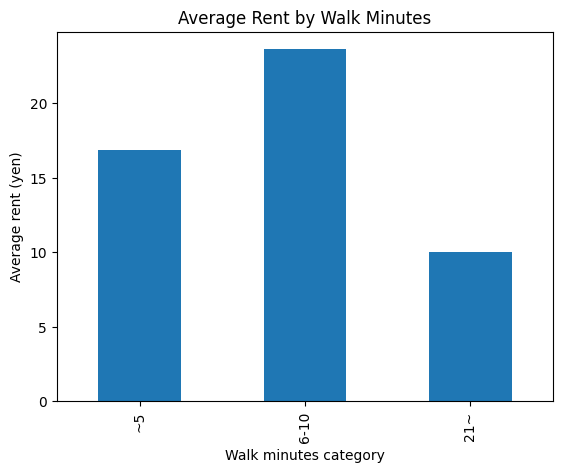

In [43]:
if __name__ == "__main__":
    analyzer = RealEstateAnalyzer("suumo.db")

    # 世田谷区だけ分析（入力で変えられる）
    df = analyzer.load_data(ward="世田谷区")

    print(f"分析件数: {len(df)}")
    print("相関係数:", analyzer.calc_correlation(df))

    analyzer.plot_scatter(df)
    analyzer.plot_average_by_walk(df)
